In [1]:
import pandas as pd
import numpy as np

csv_file_name = 'data0407_45below woX.csv'
data_np = pd.read_csv(csv_file_name).values
print(data_np.shape)

(128, 3058)


In [ ]:
features_gt = data_np[:-5,:][:,1:-2].copy()  # ID, SNP0~SNP3054, gt, tag, set_type
n_cases, n_features = features_gt.shape   # N: number of cases, n: number of features
print(f'{n_cases} x {n_features}')

123 x 3055


In [3]:
ID_list = list(data_np[:-5,0])
GT_list = list(data_np[:-5,-3].astype(np.int32))
TAG_list = list(data_np[:-5,-2])
SET_list = list(data_np[:-5,-1])
print(len(GT_list))
print('')
GT_set = list(set(GT_list))
print(GT_set)
for gt in GT_set:
    print(gt, GT_list.count(gt))
print('')
TAG_set = list(set(TAG_list))
print(TAG_set)
for tag in TAG_set:
    print(tag, TAG_list.count(tag))

123

[0, 1]
0 57
1 66

['FL', 'C', 'FE', 'NFE']
FL 21
C 57
FE 23
NFE 22


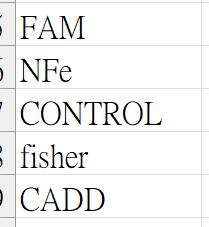

In [4]:
FAM_np = data_np[-5,1:-3].astype(np.float32)
NFe_np = data_np[-4,1:-3].astype(np.float32)
CONTROL_np = data_np[-3,1:-3].astype(np.float32)
fisher_np = data_np[-2,1:-3].astype(np.float32)
CADD_np = data_np[-1,1:-3].astype(np.float32)
print(CADD_np.shape)

(3054,)


__Split the training and testing sets based on tags__

In [5]:
# 分訓練集與測試集 + 全部特徵 + LR

import numpy as np
from sklearn.linear_model import LogisticRegression

SET_np = np.array(SET_list)
TAG_np = np.array(TAG_list)

X = features_gt[SET_np == 'training',:][:,:-1].astype(np.float32)
y = features_gt[SET_np == 'training',-1].astype(np.int32)
print(X.shape, y.shape)

X_ = features_gt[np.logical_and(SET_np =='testing', TAG_np!='TWB'),:][:,:-1].astype(np.float32)
y_ = features_gt[np.logical_and(SET_np =='testing', TAG_np!='TWB'),-1].astype(np.int32)
print(X_.shape, y_.shape)

LR = LogisticRegression()
LR.fit(X, y)

# X_ = features_gt[SET_np =='testing', ,:][:,:-1].astype(np.float32)
# y_ = features_gt[SET_np =='testing',-1].astype(np.int32)

pred = LR.predict_proba(X_)

cm = np.zeros((2,2), dtype=np.int32)
threshold = 0.5
for i in range(len(y_)):
    proba = pred[i,1]
    gt = y_[i]
    if(proba>=threshold):
        pid = 1
    else:
        pid = 0
    if(pid!=gt):
        print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
    cm[gt,pid] += 1

print('Logistic Regression')
print('cm =', cm)
acc = cm.trace()/cm.sum()
recall = cm[1,1]/cm[1,:].sum()
print('acc =', acc)
print('recall =', recall)

(88, 3054) (88,)
(35, 3054) (35,)
case_no il67, GT=1, pred=0
case_no il69, GT=1, pred=0
case_no il70, GT=1, pred=0
case_no 30, GT=1, pred=0
case_no 26, GT=1, pred=0
case_no 54, GT=1, pred=0
case_no 66, GT=1, pred=0
case_no 76, GT=1, pred=0
case_no 83, GT=1, pred=0
case_no 35, GT=1, pred=0
case_no 127, GT=1, pred=0
case_no il71, GT=1, pred=0
case_no 61, GT=1, pred=0
case_no 62, GT=1, pred=0
case_no 25, GT=1, pred=0
case_no 63, GT=1, pred=0
case_no 53, GT=1, pred=0
case_no 68, GT=1, pred=0
case_no 77, GT=1, pred=0
Logistic Regression
cm = [[13  0]
 [19  3]]
acc = 0.45714285714285713
recall = 0.13636363636363635


In [ ]:
# Split into training and testing sets + all features + RF (Random Forest)

import numpy as np
from sklearn.ensemble import RandomForestClassifier

SET_np = np.array(SET_list)
TAG_np = np.array(TAG_list)

X = features_gt[SET_np == 'training',:][:,:-1].astype(np.float32)
y = features_gt[SET_np == 'training',-1].astype(np.int32)
print(X.shape, y.shape)

RF = RandomForestClassifier(200)
RF.fit(X, y)

X_ = features_gt[SET_np =='testing',:][:,:-1].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape, y_.shape)

pred = RF.predict_proba(X_)

cm = np.zeros((2,2), dtype=np.int32)
threshold = 0.5
for i in range(len(y_)):
    proba = pred[i,1]
    gt = y_[i]
    if(proba>=threshold):
        pid = 1
    else:
        pid = 0
    if(pid!=gt):
        print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
    cm[gt,pid] += 1

print('Random Forest')
print('cm =', cm)
acc = cm.trace()/cm.sum()
recall = cm[1,1]/cm[1,:].sum()
print('acc =', acc)
print('recall =', recall)

(88, 3054) (88,)
(35, 3054) (35,)
case_no il70, GT=1, pred=0
case_no 30, GT=1, pred=0
case_no 76, GT=1, pred=0
case_no 127, GT=1, pred=0
case_no il68, GT=1, pred=0
case_no 61, GT=1, pred=0
case_no 62, GT=1, pred=0
case_no 68, GT=1, pred=0
Random Forest
cm = [[13  0]
 [ 8 14]]
acc = 0.7714285714285715
recall = 0.6363636363636364


__Subgroup Feature Analysis__

In [7]:
TAG_np = np.array(TAG_list)
SET_np = np.array(SET_list)

N = np.sum(np.logical_and(TAG_np=='FE', SET_np=='training'))
print('FE in train:', N)
N = np.sum(np.logical_and(TAG_np=='FL', SET_np=='training'))
print('FL in train:', N)
N = np.sum(np.logical_and(TAG_np=='C', SET_np=='training'))
print('C in train:', N)
N = np.sum(np.logical_and(np.logical_or(TAG_np=='FE', TAG_np=='FL'), SET_np=='training'))
print('FE + FL in train:', N)
N = np.sum(np.logical_and(TAG_np=='NFE', SET_np=='training'))
print('NFE in train:', N)
N = np.sum(np.logical_and(TAG_np=='NFE', SET_np=='testing'))
print('NFE in test:', N)
N = np.sum(np.logical_and(TAG_np=='C', SET_np=='testing'))
print('C in test:', N)

FE in train: 23
FL in train: 21
C in train: 44
FE + FL in train: 44
NFE in train: 0
NFE in test: 22
C in test: 13


In [8]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

TAG_np = np.array(TAG_list)
tag_name_list_1 = [ 'FE', 'FL', 'NFE', 'FE']
tag_name_list_2 = ['', '', '', 'FL']
n_features = features_gt[:,:-1].shape[1]
tag_features_rank = {tag_name_1+tag_name_2:[0]*n_features for tag_name_1, tag_name_2 in zip(tag_name_list_1, tag_name_list_2)}
tag_features_rank['all'] = [0]*n_features
for tag_name_1, tag_name_2 in zip(tag_name_list_1, tag_name_list_2):
    features_gt_ = features_gt[np.logical_or(np.logical_or(TAG_np==tag_name_1,TAG_np==tag_name_2),TAG_np=='C'),:].copy()
    n_cases, n_features = features_gt_[:,:-1].shape
    tag_name = tag_name_1 + tag_name_2
    print(tag_name, ':', n_cases, n_features)

    for i in range(200):
        X = features_gt_[:,:-1].astype(np.float32)
        y = features_gt_[:,-1].astype(np.float32)
        
        RF = RandomForestClassifier(200)
        RF.fit(X, y)

        F_importances = RF.feature_importances_
        F_rank = np.argsort(F_importances)[::-1]  # 由大到小
        for idx, j in enumerate(F_rank):
            tag_features_rank[tag_name][j] += idx
    tag_features_rank[tag_name] = np.argsort(tag_features_rank[tag_name])

for i in range(200):
    X = features_gt[:,:-1].astype(np.float32)
    y = features_gt[:,-1].astype(np.float32)
    
    RF = RandomForestClassifier(200)
    RF.fit(X, y)

    F_importances = RF.feature_importances_
    F_rank = np.argsort(F_importances)[::-1]  # 由大到小
    for idx, j in enumerate(F_rank):
        tag_features_rank['all'][j] += idx
tag_features_rank['all'] = np.argsort(tag_features_rank['all'])

for tag_name in tag_features_rank.keys():
    print(tag_name)
    print(tag_features_rank[tag_name][:200])

# df = pd.DataFrame(tag_features_rank)
# df.to_csv('Feature_Rank.csv', index=False) 


FE : 80 3054
FL : 78 3054
NFE : 79 3054
FEFL : 101 3054
FE
[ 552  551  927 1410 1370  156 1022  157 1021  174 1740  731  974  613
 2609 2608 2904  617 2314  782 2357 1070  173 1326  110 1400  176 2412
 2909  735 2912   69  801  276  120  614 2702  855  211 2537   73   70
 1027 1705  122 1123   44  117   43  674  577 1792  391  121  639 1143
  162  856  978  977 1811   68  119 2296 1934 1177  472  594 2361  931
   49  746  911  436  118 2436  437 1765  633 1042 2215   72 2591  165
 1525 2925 1040  328  619 1844  318  632 1786  177  805   88 1126 3052
 1168 1527  568  111 1221 1787 2358  522   35   29  232  514 1606   59
  418  231 1052 1048  511  818  147  295 2316  684   28  694  273  201
  501  187  737   60 2654 1245  966  523  100  411   95  304 2176 1036
 1010  743 2004 1131 1081 1009  925  734 1441  993  900 1837  587  824
  320  595 1324  630  554  226 2796 1545 1018 1063  618  399 2663 2289
  469  758  692 2710 1465 2065  321  352 1495  930 2337 1019  353  319
 1539  965 2157  4

In [ ]:
# Split into training and testing sets + all features + LR(Logistic Regression)

import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression

SET_np = np.array(SET_list)
records_acc = []
records_recall = []
for  num in range(5,201):
    n_select = num 
    print(f'# of selected tag features = {n_select}')

    for tag_name in tag_features_rank.keys():
        if(tag_name != 'NFE'):
            continue
        print(tag_name)
        F_rank = tag_features_rank[tag_name]
        X = features_gt[SET_np == 'training',:][:,F_rank[:n_select]].astype(np.float32)
        y = features_gt[SET_np == 'training',-1].astype(np.int32)

        LR = LogisticRegression()
        LR.fit(X, y)

        # pred = LR.predict_proba(X)
        # cm = np.zeros((2,2), dtype=np.int32)
        # threshold = 0.5
        # for i in range(len(y)):
        #     proba = pred[i,1]
        #     gt = y[i]
        #     if(proba>=threshold):
        #         pid = 1
        #     else:
        #         pid = 0
        #     # if(pid!=gt):
        #     #     print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
        #     cm[gt,pid] += 1

        # print('Training cm =', cm)
        # acc = cm.trace()/cm.sum()
        # recall = cm[1,1]/cm[1,:].sum()
        # print('Training acc =', acc)
        # print('Training recall =', recall)
        # print('')
        
        X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
        y_ = features_gt[SET_np =='testing',-1].astype(np.int32)

        pred = LR.predict_proba(X_)

        cm = np.zeros((2,2), dtype=np.int32)
        threshold = 0.5
        for i in range(len(y_)):
            proba = pred[i,1]
            gt = y_[i]
            if(proba>=threshold):
                pid = 1
            else:
                pid = 0
            # if(pid!=gt):
            #     print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
            cm[gt,pid] += 1

        print('cm =', cm)
        acc = cm.trace()/cm.sum()
        recall = cm[1,1]/cm[1,:].sum()
        print('acc =', acc)
        print('recall =', recall)
        records_acc.append(acc)
        records_recall.append(recall)
        print('')

# of selected tag features = 5
NFE
cm = [[13  0]
 [ 4 18]]
acc = 0.8857142857142857
recall = 0.8181818181818182

# of selected tag features = 6
NFE
cm = [[13  0]
 [ 4 18]]
acc = 0.8857142857142857
recall = 0.8181818181818182

# of selected tag features = 7
NFE
cm = [[13  0]
 [ 3 19]]
acc = 0.9142857142857143
recall = 0.8636363636363636

# of selected tag features = 8
NFE
cm = [[13  0]
 [ 1 21]]
acc = 0.9714285714285714
recall = 0.9545454545454546

# of selected tag features = 9
NFE
cm = [[13  0]
 [ 1 21]]
acc = 0.9714285714285714
recall = 0.9545454545454546

# of selected tag features = 10
NFE
cm = [[13  0]
 [ 0 22]]
acc = 1.0
recall = 1.0

# of selected tag features = 11
NFE
cm = [[13  0]
 [ 1 21]]
acc = 0.9714285714285714
recall = 0.9545454545454546

# of selected tag features = 12
NFE
cm = [[13  0]
 [ 1 21]]
acc = 0.9714285714285714
recall = 0.9545454545454546

# of selected tag features = 13
NFE
cm = [[13  0]
 [ 2 20]]
acc = 0.9428571428571428
recall = 0.9090909090909091

# of sele

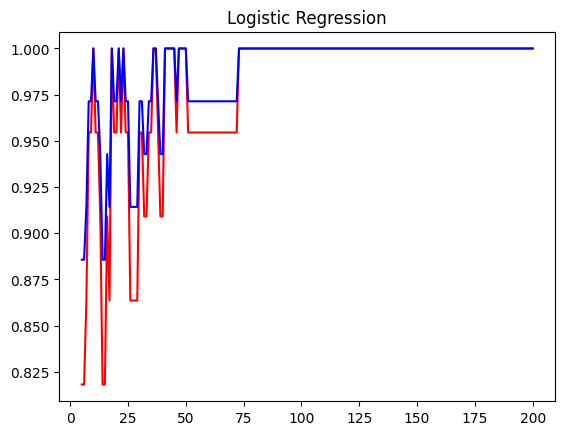

In [10]:
import matplotlib.pyplot as plt

x = list(range(5,201))
plt.plot(x, records_recall, color = 'r')
plt.plot(x, records_acc, color = 'b')
plt.title('Logistic Regression')
plt.show()

In [ ]:
# Split into training and testing sets + selected features + RF (Random Forest)

from sklearn.ensemble import RandomForestClassifier
import numpy as np

SET_np = np.array(SET_list)
records_acc = []
records_recall = []
for  num in range(5,201):
    n_select = num 
    print(f'# of selected tag features = {n_select}')

    for tag_name in tag_features_rank.keys():
        if(tag_name != 'NFE'):
            continue
        print(tag_name)
        F_rank = tag_features_rank[tag_name]
        X = features_gt[SET_np == 'training',:][:,F_rank[:n_select]].astype(np.float32)
        y = features_gt[SET_np == 'training',-1].astype(np.int32)

        RF = RandomForestClassifier(200)
        RF.fit(X, y)

        # pred = RF.predict_proba(X)
        # cm = np.zeros((2,2), dtype=np.int32)
        # threshold = 0.5
        # for i in range(len(y)):
        #     proba = pred[i,1]
        #     gt = y[i]
        #     if(proba>=threshold):
        #         pid = 1
        #     else:
        #         pid = 0
        #     # if(pid!=gt):
        #     #     print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
        #     cm[gt,pid] += 1

        # print('Training cm =', cm)
        # acc = cm.trace()/cm.sum()
        # recall = cm[1,1]/cm[1,:].sum()
        # print('Training acc =', acc)
        # print('Training recall =', recall)
        # print('')
        
        X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
        y_ = features_gt[SET_np =='testing',-1].astype(np.int32)

        pred = RF.predict_proba(X_)

        cm = np.zeros((2,2), dtype=np.int32)
        threshold = 0.5
        for i in range(len(y_)):
            proba = pred[i,1]
            gt = y_[i]
            if(proba>=threshold):
                pid = 1
            else:
                pid = 0
            # if(pid!=gt):
            #     print(f'case_no {ID_list[i]}, GT={gt}, pred={pid}')
            cm[gt,pid] += 1

        print('cm =', cm)
        acc = cm.trace()/cm.sum()
        recall = cm[1,1]/cm[1,:].sum()
        print('acc =', acc)
        print('recall =', recall)
        records_acc.append(acc)
        records_recall.append(recall)
        print('')

# of selected tag features = 5
NFE
cm = [[13  0]
 [ 3 19]]
acc = 0.9142857142857143
recall = 0.8636363636363636

# of selected tag features = 6
NFE
cm = [[13  0]
 [ 2 20]]
acc = 0.9428571428571428
recall = 0.9090909090909091

# of selected tag features = 7
NFE
cm = [[13  0]
 [ 0 22]]
acc = 1.0
recall = 1.0

# of selected tag features = 8
NFE
cm = [[12  1]
 [ 1 21]]
acc = 0.9428571428571428
recall = 0.9545454545454546

# of selected tag features = 9
NFE
cm = [[12  1]
 [ 1 21]]
acc = 0.9428571428571428
recall = 0.9545454545454546

# of selected tag features = 10
NFE
cm = [[12  1]
 [ 0 22]]
acc = 0.9714285714285714
recall = 1.0

# of selected tag features = 11
NFE
cm = [[12  1]
 [ 0 22]]
acc = 0.9714285714285714
recall = 1.0

# of selected tag features = 12
NFE
cm = [[12  1]
 [ 0 22]]
acc = 0.9714285714285714
recall = 1.0

# of selected tag features = 13
NFE
cm = [[13  0]
 [ 0 22]]
acc = 1.0
recall = 1.0

# of selected tag features = 14
NFE
cm = [[13  0]
 [ 2 20]]
acc = 0.9428571428571428

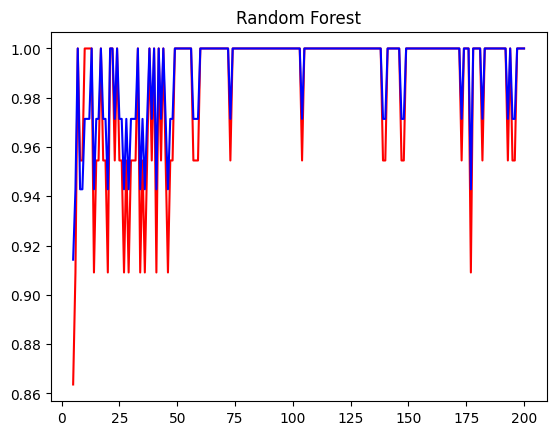

In [12]:
import matplotlib.pyplot as plt

x = list(range(5,201))
plt.plot(x, records_recall, color = 'r')
plt.plot(x, records_acc, color = 'b')
plt.title('Random Forest')
plt.show()

(35, 100)
(35, 2)


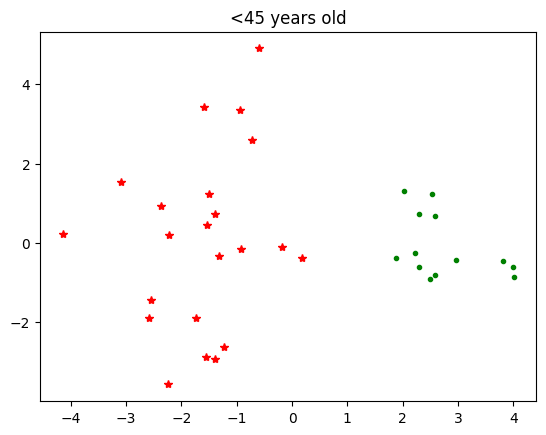

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_select = 100
F_rank = tag_features_rank['NFE']
X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

pca = PCA(n_components=2)
pca.fit(X_)
new_X = pca.transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(y_[i]==0):
        plt.plot(xi,yi,'g.')
    else:
        plt.plot(xi,yi,'r*')
plt.title('<45 years old')
plt.show()

(35, 100)
(35, 2)


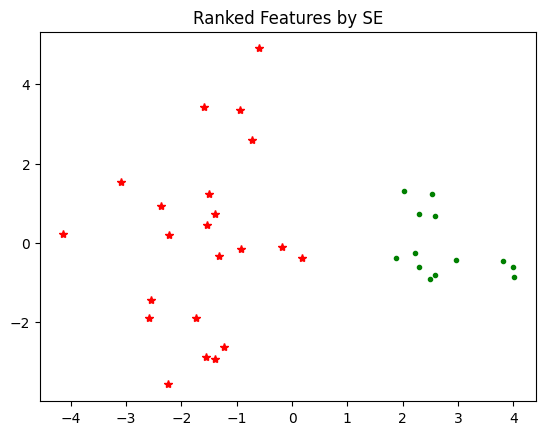

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_select = 100
F_rank = tag_features_rank['NFE']
X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

pca = PCA(n_components=2)
pca.fit(X_)
new_X = pca.transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(y_[i]==0):
        plt.plot(xi,yi,'g.')
    else:
        plt.plot(xi,yi,'r*')
plt.title('Ranked Features by SE')
plt.show()

(35, 3055)
(35, 2)


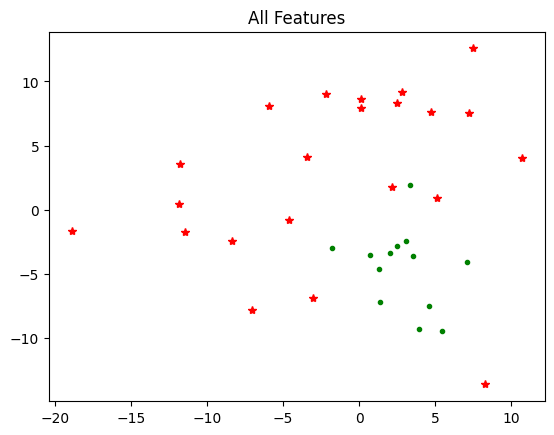

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_select = 100
F_rank = tag_features_rank['NFE']
X_ = features_gt[SET_np =='testing',:].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

pca = PCA(n_components=2)
pca.fit(X_)
new_X = pca.transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(y_[i]==0):
        plt.plot(xi,yi,'g.')
    else:
        plt.plot(xi,yi,'r*')
plt.title('All Features')
plt.show()

(35, 100)
(35, 2)


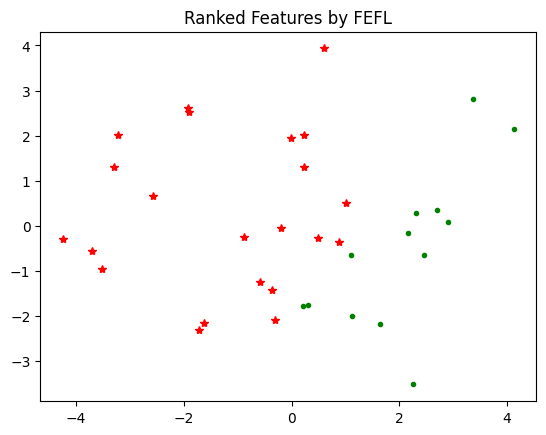

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_select = 100
F_rank = tag_features_rank['FEFL']
X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

pca = PCA(n_components=2)
pca.fit(X_)
new_X = pca.transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(y_[i]==0):
        plt.plot(xi,yi,'g.')
    else:
        plt.plot(xi,yi,'r*')
plt.title('Ranked Features by FEFL')
plt.show()

In [18]:
# 分訓練集與測試集 + 全部特徵 + LR

import numpy as np
from sklearn.linear_model import LogisticRegression

n_select = 100

SET_np = np.array(SET_list)
TAG_np = np.array(TAG_list)
F_rank = tag_features_rank['NFE']
X = features_gt[SET_np == 'training',:][:,F_rank[:n_select]].astype(np.float32)
y = features_gt[SET_np == 'training',-1].astype(np.int32)
print('training:', X.shape, y.shape)

LR_NFE = LogisticRegression()
LR_NFE.fit(X, y)

X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
ID_test_np = np.array(ID_list)[SET_np=='testing']
print('tesing:', X_.shape, y_.shape)

pred = LR_NFE.predict_proba(X_)

cm = np.zeros((2,2), dtype=np.int32)
threshold = 0.5
for i in range(len(y_)):
    proba = pred[i,1]
    gt = y_[i]
    if(proba>=threshold):
        pid = 1
    else:
        pid = 0
    if(pid!=gt):
        print(f'case_no {ID_test_np[i]}, GT={gt}, pred={pid}, {SRC_test_np[i]}')
    cm[gt,pid] += 1

print('Logistic Regression')
print('cm =', cm)
acc = cm.trace()/cm.sum()
recall = cm[1,1]/cm[1,:].sum()
print('acc =', acc)
print('recall =', recall)

training: (88, 100) (88,)
tesing: (35, 100) (35,)
Logistic Regression
cm = [[13  0]
 [ 0 22]]
acc = 1.0
recall = 1.0


(35, 100)
(35, 2)


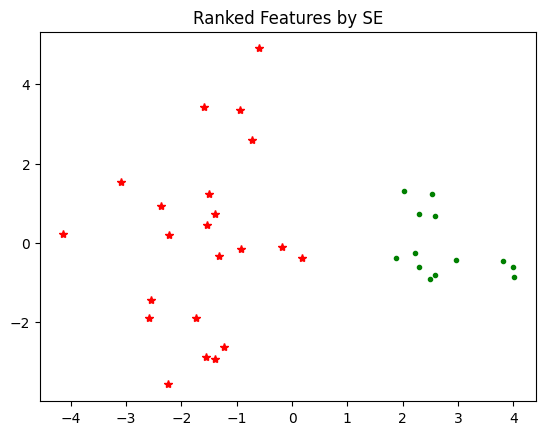

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_select = 100
F_rank = tag_features_rank['NFE']
X_ = features_gt[SET_np =='testing',:][:,F_rank[:n_select]].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

pca_nfe = PCA(n_components=2)
pca_nfe.fit(X_)
new_X = pca_nfe.transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(y_[i]==0):
        plt.plot(xi,yi,'g.')
    else:
        plt.plot(xi,yi,'r*')
plt.title('Ranked Features by SE')
plt.show()

In [1]:
import pandas as pd
import numpy as np

csv_file_name = 'data0407_45below woX.csv'
data_np = pd.read_csv(csv_file_name).values
print(data_np.shape)

(128, 3058)


In [2]:
ID_list = list(data_np[:-5,0])
GT_list = list(data_np[:-5,-3].astype(np.int32))
TAG_list = list(data_np[:-5,-2])
SET_list = list(data_np[:-5,-1])
print(len(GT_list))
print('')
GT_set = list(set(GT_list))
print(GT_set)
for gt in GT_set:
    print(gt, GT_list.count(gt))
print('')
TAG_set = list(set(TAG_list))
print(TAG_set)
for tag in TAG_set:
    print(tag, TAG_list.count(tag))

123

[0, 1]
0 57
1 66

['NFE', 'FE', 'C', 'FL']
NFE 22
FE 23
C 57
FL 21


__Age-Stratified PCA analysis__

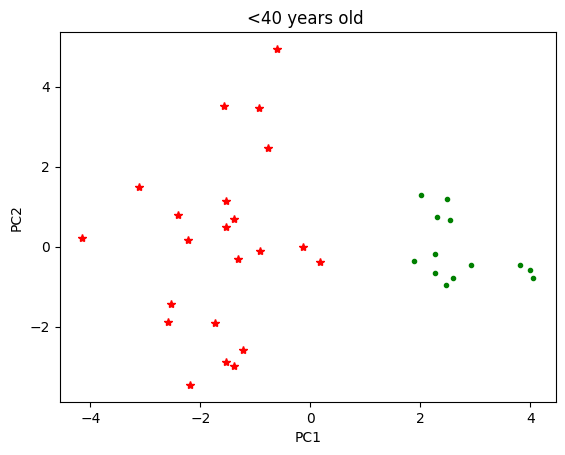

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === Step 1: 讀檔 + 篩選 set_type == 'testing'，且 gt 不能是 NaN
df = pd.read_csv("data0407_45below woX.csv")
df = df[df['set_type'] == 'testing']       # 只留 testing 組
df = df[df['gt'].notna()]                  # 移除底部 FAM, fisher 等行
df = df.reset_index(drop=True)             # 重設索引

# === Step 2: 標籤與特徵
y_ = df['gt'].astype(int).values
X_ = df.iloc[:, 1:3056].astype(np.float32).values  

# === Step 3: 指定前100個特徵
F_rank = np.array([1410, 552, 551, 2610, 613, 1705, 68, 2909, 2607, 934, 855, 69, 2241, 2904, 800, 2668, 
                   667, 614, 1628, 2075, 187, 1370, 1421, 2165, 1423, 927, 3052, 2215, 2113, 1274, 1528, 
                   1319, 2910, 925, 1220, 691, 70, 2030, 608, 1857, 13, 14, 174, 74, 1219, 3043, 2663, 1345, 
                   1187, 1465, 2250, 1010, 3044, 1559, 947, 1195, 1190, 2277, 2881, 73, 1017, 2661, 173, 792, 
                   1858, 751, 1442, 1243, 2724, 1739, 752, 674, 2019, 2693, 1516, 1940, 2065, 731, 804, 2745, 
                   164, 499, 1916, 2796, 1515, 2041, 978, 2788, 1787, 1201, 989, 6, 523, 508, 2424, 300, 1558, 2816])
F_rank = F_rank[F_rank < X_.shape[1]]
X_sel = X_[:, F_rank]

# === Step 4: PCA
pca = PCA(n_components=2)
pca.fit(X_)
new_X = pca.fit_transform(X_sel)

# === Step 5: Plot
for i in range(len(y_)):
    xi, yi = new_X[i]
    if y_[i] == 0:
        plt.plot(xi, yi, 'g.')
    else:
        plt.plot(xi, yi, 'r*')

plt.title('<40 years old ')
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.grid(True)
plt.show()


In [12]:
import pandas as pd
import numpy as np

# csv_file_name = 'data0407_45below woX.csv'
# csv_file_name = 'data0407_below55-NFLcorrect woX.csv'
csv_file_name = 'data0407_all cases-NFLcorrect woX.csv'

data_np = pd.read_csv(csv_file_name).values
print(data_np.shape)

features_gt = data_np[:-5,:][:,1:-2].copy()  # ID, SNP0~SNP2569, gt, tag, set_type
n_cases, n_features = features_gt.shape   # N: number of cases, n: number of features
print(f'{n_cases} x {n_features}')

ID_list = list(data_np[:-5,0])
GT_list = list(data_np[:-5,-3].astype(np.int32))
TAG_list = list(data_np[:-5,-2])
SET_list = list(data_np[:-5,-1])
print(len(GT_list))
print('')
GT_set = list(set(GT_list))
print(GT_set)
for gt in GT_set:
    print(gt, GT_list.count(gt))
print('')
TAG_set = list(set(TAG_list))
print(TAG_set)
for tag in TAG_set:
    print(tag, TAG_list.count(tag))

(155, 3058)
150 x 3055
150

[0, 1]
0 57
1 93

['NFL', 'FL', 'C', 'NFE', 'FE']
NFL 27
FL 21
C 57
NFE 22
FE 23


(62, 98)
(62, 2)


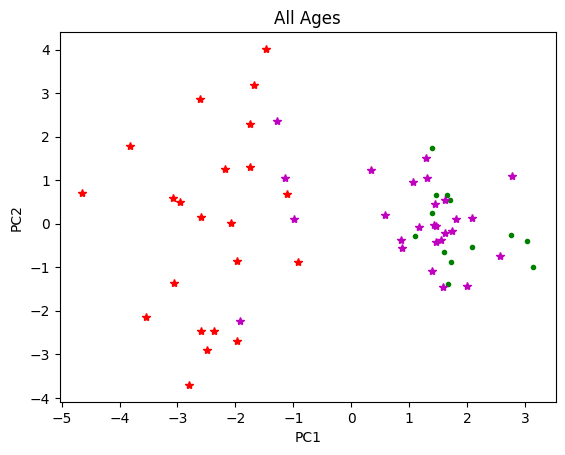

In [15]:
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

SET_np = np.array(SET_list)
TAG_np = np.array(TAG_list)
TAG_info = TAG_np[SET_np=='testing']

# n_select = 100
# F_rank = tag_features_rank['NFE']
F_rank=np.array([1410, 552, 551, 2610, 613, 1705, 68, 2909, 2607, 934, 855, 69, 2241, 2904, 800, 2668, 
                 667, 614, 1628, 2075, 187, 1370, 1421, 2165, 1423, 927, 3052, 2215, 2113, 1274, 1528, 
                 1319, 2910, 925, 1220, 691, 70, 2030, 608, 1857, 13, 14, 174, 74, 1219, 3043, 2663, 1345, 
                 1187, 1465, 2250, 1010, 3044, 1559, 947, 1195, 1190, 2277, 2881, 73, 1017, 2661, 173, 792, 1858, 
                 751, 1442, 1243, 2724, 1739, 752, 674, 2019, 2693, 1516, 1940, 2065, 731, 804, 2745, 164, 499, 
                 1916, 2796, 1515, 2041, 978, 2788, 1787, 1201, 989, 6, 523, 508, 2424, 300, 1558, 2816])
X_ = features_gt[SET_np =='testing',:][:,F_rank].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

# pca = PCA(n_components=2)
# pca.fit(X_)
new_X = pca.fit_transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    f = X_[i,:]
    # prob = LR_NFE.predict_proba(f.reshape(1,-1))
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(TAG_info[i]=='NFL'):
        if(y_[i]==0):
            plt.plot(xi,yi,'y.')
        else:
            plt.plot(xi,yi,'m*')
    else:
        if(y_[i]==0):
            plt.plot(xi,yi,'g.')
        else:
            plt.plot(xi,yi,'r*')
    # plt.text(xi,yi,str(round(prob[0,1],2)))
plt.title('All Ages')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [17]:
import pandas as pd
import numpy as np

# csv_file_name = 'data0407_45below woX.csv'
csv_file_name = 'data0407_below55-NFLcorrect woX.csv'
# csv_file_name = 'data0407_all cases-NFLcorrect woX.csv'

data_np = pd.read_csv(csv_file_name).values
print(data_np.shape)

features_gt = data_np[:-5,:][:,1:-2].copy()  # ID, SNP0~SNP2569, gt, tag, set_type
n_cases, n_features = features_gt.shape   # N: number of cases, n: number of features
print(f'{n_cases} x {n_features}')

ID_list = list(data_np[:-5,0])
GT_list = list(data_np[:-5,-3].astype(np.int32))
TAG_list = list(data_np[:-5,-2])
SET_list = list(data_np[:-5,-1])
print(len(GT_list))
print('')
GT_set = list(set(GT_list))
print(GT_set)
for gt in GT_set:
    print(gt, GT_list.count(gt))
print('')
TAG_set = list(set(TAG_list))
print(TAG_set)
for tag in TAG_set:
    print(tag, TAG_list.count(tag))

(133, 3058)
128 x 3055
128

[0, 1]
0 57
1 71

['NFL', 'FL', 'C', 'NFE', 'FE']
NFL 5
FL 21
C 57
NFE 22
FE 23


(40, 98)
(40, 2)


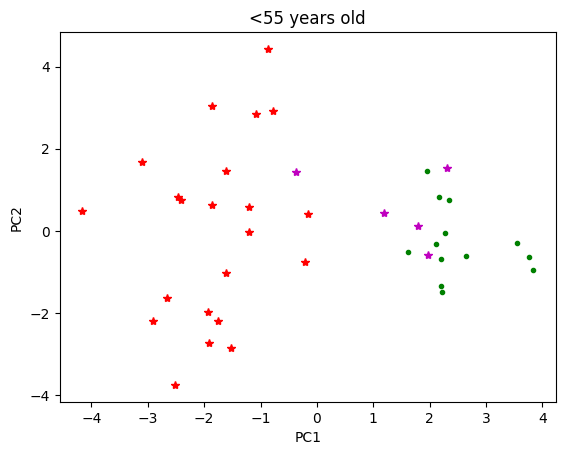

In [18]:
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

SET_np = np.array(SET_list)
TAG_np = np.array(TAG_list)
TAG_info = TAG_np[SET_np=='testing']

# n_select = 100
# F_rank = tag_features_rank['NFE']
F_rank=np.array([1410, 552, 551, 2610, 613, 1705, 68, 2909, 2607, 934, 855, 69, 2241, 2904, 800, 2668, 
                 667, 614, 1628, 2075, 187, 1370, 1421, 2165, 1423, 927, 3052, 2215, 2113, 1274, 1528, 
                 1319, 2910, 925, 1220, 691, 70, 2030, 608, 1857, 13, 14, 174, 74, 1219, 3043, 2663, 1345, 
                 1187, 1465, 2250, 1010, 3044, 1559, 947, 1195, 1190, 2277, 2881, 73, 1017, 2661, 173, 792, 1858, 
                 751, 1442, 1243, 2724, 1739, 752, 674, 2019, 2693, 1516, 1940, 2065, 731, 804, 2745, 164, 499, 
                 1916, 2796, 1515, 2041, 978, 2788, 1787, 1201, 989, 6, 523, 508, 2424, 300, 1558, 2816])
X_ = features_gt[SET_np =='testing',:][:,F_rank].astype(np.float32)
# X_ = features_gt[SET_np =='testing',:].astype(np.float32)
y_ = features_gt[SET_np =='testing',-1].astype(np.int32)
print(X_.shape)

# pca = PCA(n_components=2)
# pca.fit(X_)
new_X = pca.fit_transform(X_)
print(new_X.shape)

N = new_X.shape[0]
for i in range(N):
    f = X_[i,:]
    # prob = LR_NFE.predict_proba(f.reshape(1,-1))
    xi,yi = new_X[i,:]
    # print(xi, yi, y_[i])
    if(TAG_info[i]=='NFL'):
        if(y_[i]==0):
            plt.plot(xi,yi,'y.')
        else:
            plt.plot(xi,yi,'m*')
    else:
        if(y_[i]==0):
            plt.plot(xi,yi,'g.')
        else:
            plt.plot(xi,yi,'r*')
    # plt.text(xi,yi,str(round(prob[0,1],2)))
plt.title('<55 years old')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [24]:
import pandas as pd
import numpy as np

# csv_file_name = 'data0407_45below woX.csv'
csv_file_name = 'data_0428 all.csv'
# csv_file_name = 'data0407_all cases-NFLcorrect woX.csv'

data_np = pd.read_csv(csv_file_name).values
print(data_np.shape)

features_gt = data_np[:-5,:][:,1:-2].copy()  # ID, SNP0~SNP2569, gt, tag, set_type
n_cases, n_features = features_gt.shape   # N: number of cases, n: number of features
print(f'{n_cases} x {n_features}')

ID_list = list(data_np[:-5,0])
GT_list = list(data_np[:-5,-3].astype(np.int32))
TAG_list = list(data_np[:-5,-2])
SET_list = list(data_np[:-5,-1])
print(len(GT_list))
print('')
GT_set = list(set(GT_list))
print(GT_set)
for gt in GT_set:
    print(gt, GT_list.count(gt))
print('')
TAG_set = list(set(TAG_list))
print(TAG_set)
for tag in TAG_set:
    print(tag, TAG_list.count(tag))

(164, 3058)
159 x 3055
159

[0, 1]
0 57
1 102

['NFE', 'FE', 'FL', 'C', 'S', 'NFL']
NFE 22
FE 23
FL 21
C 57
S 9
NFL 27


__Model-Derived Probability Output__

In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 選用特徵數
n_select = 100

# 原有資料
SET_np = np.array(SET_list)  # 原本training/testing標籤
TAG_np = np.array(TAG_list)  # Group標籤（FE, FL, NFE, NFL, S, Control）
ID_np = np.array(ID_list)

# 特徵重要度排序
F_rank = tag_features_rank['NFE']

# 🧪 訓練模型 (只用 training set 訓練)
X_train = features_gt[SET_np == 'training', :][:, F_rank[:n_select]].astype(np.float32)
y_train = features_gt[SET_np == 'training', -1].astype(np.int32)
print('Training:', X_train.shape, y_train.shape)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 🔎 預測 全部樣本（包含training+testing+Suspect）
X_all = features_gt[:, :][:, F_rank[:n_select]].astype(np.float32)
y_all = features_gt[:, -1].astype(np.int32)
print('All samples:', X_all.shape, y_all.shape)

# 預測所有人的機率
pred_all = model.predict_proba(X_all)
predicted_probs = pred_all[:, 1]  # 預測為Case的機率
predicted_labels = (predicted_probs >= 0.5).astype(int)

# ✅ 整理所有人的資料
df_output = pd.DataFrame({
    'ID': ID_np,
    'Group': TAG_np,
    'Set': SET_np,            # 加上是training還是testing，方便你對照
    'TrueLabel': y_all,
    'PredictedProb': predicted_probs,
    'PredictedLabel': predicted_labels
})

# 輸出成CSV
df_output.to_csv("LR_NFE_output_all_people.csv", index=False)

print("\n✅ 預測機率值表格已輸出：LR_NFE_output_all_people.csv")
print(df_output.head())


Training: (88, 100) (88,)
All samples: (159, 100) (159,)

✅ 預測機率值表格已輸出：LR_NFE_output_all_people.csv
     ID Group       Set  TrueLabel  PredictedProb  PredictedLabel
0  il67    FE  training          1       0.958882               1
1  il69    FE  training          1       0.919726               1
2  il70    FE  training          1       0.977688               1
3    30    FE  training          1       0.971264               1
4    26    FE  training          1       0.854973               1
